In [ ]:
# !pip install pretrainedmodels==0.7.4
# !pip install efficientnet-pytorch==0.6.3
# !pip install timm==0.3.2

In [ ]:
# # 1.6.0 버전
# !pip install torch==1.6.0
# !pip install torchvision==0.7.0

In [1]:
!nvidia-smi

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="4"

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import SimpleITK as sitk
import cv2
from tqdm import tqdm

import sys
sys.path.append(os.path.abspath('/workspace/sunggu'))
sys.path.append(os.path.abspath('/workspace/sunggu/4.Dose_img2img/utils'))
sys.path.append(os.path.abspath('/workspace/sunggu/MONAI'))
from sunggu_utils import check_value, take_list, plot_confusion_matrix, list_sort_nicely, find_dir, plot_3D

import piq

Thu Sep 23 01:22:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 8000     Off  | 00000000:1B:00.0 Off |                  Off |
| 33%   53C    P2   231W / 260W |  43010MiB / 48601MiB |     98%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Quadro RTX 8000     Off  | 00000000:1C:00.0 Off |                  Off |
| 44%   

In [2]:
torch.__version__

'1.8.0+cu111'

## Setup imports

In [3]:
import glob
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import torch
import skimage
import monai

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import CacheDataset, DataLoader, Dataset
from monai.inferers import sliding_window_inference
from monai.losses import DiceLoss, GeneralizedDiceLoss, FocalLoss, TverskyLoss, NoiseRobustDiceLoss
from monai.metrics import compute_meandice, DiceMetric, ConfusionMatrixMetric 
from monai.networks.layers import Norm
from monai.networks.nets import UNet, highresnet
from monai.transforms import (
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadNiftid,
    LoadNumpyd,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    Lambdad,
    ToTensord,
    RandScaleIntensityd,
    RandGaussianNoised,
    RandFlipd,
    RandZoomd,
    RandGaussianNoised,
    RandGaussianSmoothd,
    RandShiftIntensityd,
    SpatialPadd,
    RandAffined,
    CastToTyped,
    DeleteItemsd,
    FgBgToIndicesd,
    Rand3DElasticd,
    RandZoomd,
    Rand2DElasticd,
    RandWeightedCropd,
    AsDiscrete,
    SpatialPadd,
    adaptor,
)
from monai.utils import first, set_determinism

print_config()

MONAI version: 0+unknown
Python version: 3.6.9 (default, Jul 17 2020, 12:50:27)  [GCC 8.4.0]
OS version: Linux (4.15.0-154-generic)
Numpy version: 1.18.5
Pytorch version: 1.8.0+cu111
MONAI flags: HAS_EXT = False, USE_COMPILED = False

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.2.1
scikit-image version: 0.17.2
Pillow version: 8.0.1
Tensorboard version: 2.3.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.9.0+cu111
ITK version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.54.1

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Set 시드

In [4]:
import random

random_seed = 7
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

set_determinism(seed=7)

## Set Test

In [5]:
low_imgs      = list_sort_nicely(glob.glob('/workspace/sunggu/4.Dose_img2img/dataset/*Brain_3mm_NPY/Test/*/20/*/*/*.npy'))
high_imgs     = list_sort_nicely(glob.glob('/workspace/sunggu/4.Dose_img2img/dataset/*Brain_3mm_NPY/Test/*/X/*/*/*.npy'))

dcm_low_imgs  = list_sort_nicely(glob.glob('/workspace/sunggu/4.Dose_img2img/dataset/*Brain_3mm_DCM/Test/*/20/*/*/*.dcm'))
dcm_high_imgs = list_sort_nicely(glob.glob('/workspace/sunggu/4.Dose_img2img/dataset/*Brain_3mm_DCM/Test/*/X/*/*/*.dcm'))

test_files = [{"low": low_name, "high": high_name, "dcm_low" : dcm_low, "dcm_high" : dcm_high} for low_name, high_name, dcm_low, dcm_high in zip(low_imgs, high_imgs, dcm_low_imgs, dcm_high_imgs)]

print("TEST [Total]  number = ", len(low_imgs))

TEST [Total]  number =  859


## Augmentation

In [6]:
# CT에 맞는 Augmentation
from torchvision import transforms
test_transforms = Compose(
    [
        LoadNumpyd(keys=["low", "high"]),
        AddChanneld(keys=["low", "high"]), 
#         CenterSpatialCropd(keys=["low", "high"], roi_size=(256, 256)),
        ToTensord(keys=["low", "high"]),
        Lambdad(keys=["low", "high"], func=transforms.Normalize(mean=(0.5), std=(0.5))),
    ]
)

## Check transforms in DataLoader

In [7]:
def visual_windowing(x):
    x = (x * 0.5) + 0.5 
    x = np.clip(x, a_min=0.250, a_max=0.270)
    x -= x.min()
    x /= x.max()  
    
    return x

/workspace/sunggu/4.Dose_img2img/dataset/[sinogram]Brain_3mm_NPY/Test/CHO_SEU_M53/20/Head^01_ER_BrainSpiral_(Adult)_Standard_-_WFBP_20210521_163914/Brain_Axial_B40f_3.0_(3.0)_[A,0]/CHO_SEU_M53_001_20210521_164102_00021.npy
/workspace/sunggu/4.Dose_img2img/dataset/[sinogram]Brain_3mm_NPY/Test/CHO_SEU_M53/X/Head^01_ER_BrainSpiral_(Adult)_Standard_-_WFBP_20210521_163707/Brain_Axial_B40f_3.0_(3.0)_[A,0]/CHO_SEU_M53_001_20210521_163912_00021.npy
image shape: torch.Size([512, 512])


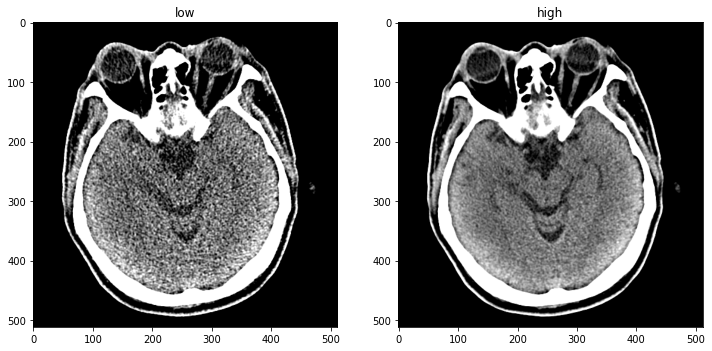

In [8]:
check_ds = Dataset(data=test_files, transform=test_transforms)
# check_loader = DataLoader(check_ds, batch_size=1, shuffle=False)
# check_data = next(iter(check_loader))

check_data = check_ds[300]

print(check_data['low_meta_dict']['filename_or_obj'])
print(check_data['high_meta_dict']['filename_or_obj'])

low = (check_data["low"][0])
high = (check_data["high"][0])
print(f"image shape: {low.shape}")

plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("low")
plt.imshow(visual_windowing(low), cmap="gray")

plt.subplot(1, 2, 2)
plt.title("high")
plt.imshow(visual_windowing(high), cmap="gray")

plt.show()

In [9]:
import multiprocessing
print("CPU 갯수 = ", multiprocessing.cpu_count())

# Cachedataset 이거 뭔가 문제가 있음...
test_ds = Dataset(data=test_files, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=12, drop_last=False)

CPU 갯수 =  64


## Create Model, Loss, Optimizer

In [10]:
from OT_CycleGAN_sunggu.models import *
from Cyclegan_sunggu.util import *
import itertools

device = 'cuda'

# 모델
netG_low_2_high = OT_Generator(in_channels=1, out_channels=1, feature=64)
netG_high_2_low = OT_Generator(in_channels=1, out_channels=1, feature=64)

netD_low  = OT_Discriminator(in_channels=1, out_channels=1, feature=64)
netD_high = OT_Discriminator(in_channels=1, out_channels=1, feature=64)
    

## 네트워크 불러오기

In [11]:
## 네트워크 불러오기
checkpoint_dir = '/workspace/sunggu/4.Dose_img2img/model/OT_Cycle_Gan_2D_sinogram_fullbatch/epoch_340_model.pth'
checkpoint = torch.load(checkpoint_dir)

epoch = checkpoint['epoch']

netG_low_2_high.load_state_dict(checkpoint['netG_low_2_high_state_dict'])
netG_high_2_low.load_state_dict(checkpoint['netG_high_2_low_state_dict'])
netD_low.load_state_dict(checkpoint['netD_low_state_dict'])
netD_high.load_state_dict(checkpoint['netD_high_state_dict'])
     
    
netG_low_2_high.to('cuda')  
netG_high_2_low.to('cuda')  
netD_low.to('cuda')  
netD_high.to('cuda')  


OT_Discriminator(
  (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (leaky1): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (instance2): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (leaky2): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (instance3): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (leaky3): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (instance4): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (leaky4): LeakyReLU(negative_slope=0.2, inplace=True)
  (last): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (output): Sigmoid()
)

## TEST

In [12]:
## 그밖에 부수적인 functions 설정하기
fn_tonumpy = lambda x: x.cpu().detach().numpy().transpose(0, 2, 3, 1)
fn_denorm = lambda x: (x * 0.5) + 0.5
fn_denorm_window  = visual_windowing

In [13]:
def return_preprocessing(x):
    x = (4095.0)*x - 1024.0
    return x

def return_preprocessing_for_dcm(x):
    x = (4095.0)*x
    return x

In [14]:
import numpy as np
from pydicom import dcmread

def save_dicom(original_dcm_path, np_img, save_path):
    dcm = dcmread(original_dcm_path)
    
    print(np_img.max(), np_img.min(), np_img.dtype)
    
    dcm.PixelData = np_img.astype('uint16').squeeze().tobytes()
    
    dcm.save_as(save_path)
    print(save_path)

In [16]:
test_low2high_save_folder = '/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_'+str(epoch) + '/low2high/'
test_low2high_png_folder  = '/workspace/sunggu/4.Dose_img2img/Predictions/Test/png/CycleGAN_OT_epoch_'+str(epoch) + '/low2high/'

with torch.no_grad():
    # Model 선언
    netG_low_2_high.eval()
    netG_high_2_low.eval()
    netD_low.eval()
    netD_high.eval()

    test_iterator = tqdm(test_loader, desc='Test', file=sys.stdout)    
    for batch_data in test_iterator:

        os.makedirs(test_low2high_save_folder+batch_data['dcm_low'][0].split('/')[8], mode=0o777, exist_ok=True)
        os.makedirs(test_low2high_save_folder+batch_data['dcm_high'][0].split('/')[8], mode=0o777, exist_ok=True)
        os.makedirs(test_low2high_png_folder+batch_data['dcm_low'][0].split('/')[8], mode=0o777, exist_ok=True)
        
        # forward pass
        input_low  = batch_data['low'].to(device)
        input_high = batch_data['high'].to(device)
        
        # Forward Generator
        output_high = netG_low_2_high(input_low)

        # 저장하기
#         print(input_low.min(), input_low.max())
#         input_low[:, 128:128+256, 128:128+256, :] = 0
        input_low_dcm   = fn_tonumpy(return_preprocessing_for_dcm(fn_denorm(input_low)))
        input_high_dcm  = fn_tonumpy(return_preprocessing_for_dcm(fn_denorm(input_high)))
        output_high_dcm = fn_tonumpy(return_preprocessing_for_dcm(fn_denorm(output_high)))

        save_dicom(batch_data['dcm_low'][0],  input_low_dcm,   test_low2high_save_folder+batch_data['dcm_low'][0].split('/')[8]+'/gt_low_' +batch_data['dcm_low'][0].split('/')[-1])        
        save_dicom(batch_data['dcm_high'][0], input_high_dcm,  test_low2high_save_folder+batch_data['dcm_high'][0].split('/')[8]+'/gt_high_' +batch_data['dcm_high'][0].split('/')[-1])
        save_dicom(batch_data['dcm_low'][0],  output_high_dcm, test_low2high_save_folder+batch_data['dcm_low'][0].split('/')[8]+'/pred_high_' +batch_data['dcm_low'][0].split('/')[-1])        

        
        # png Save
        input_low   = fn_denorm_window(fn_tonumpy((input_low)))
        input_high  = fn_denorm_window(fn_tonumpy((input_high)))
        output_high = fn_denorm_window(fn_tonumpy((output_high)))

        input_low   = np.clip(input_low, a_min=0, a_max=1)
        input_high  = np.clip(input_high, a_min=0, a_max=1)
        output_high = np.clip(output_high, a_min=0, a_max=1)
        
#         plt.imsave(test_low2high_png_folder+batch_data['dcm_low'][0].split('/')[8]+'/gt_low_' +batch_data['dcm_low'][0].split('/')[-1].replace('.dcm', '.png'),
#                    input_low[0].squeeze(),   cmap="gray")
#         plt.imsave(test_low2high_png_folder+batch_data['dcm_high'][0].split('/')[8]+'/gt_high_' +batch_data['dcm_high'][0].split('/')[-1].replace('.dcm', '.png'),
#                    input_high[0].squeeze(),   cmap="gray")
#         plt.imsave(test_low2high_png_folder+batch_data['dcm_low'][0].split('/')[8]+'/pred_high_' +batch_data['dcm_low'][0].split('/')[-1].replace('.dcm', '.png'),
#                    output_high[0].squeeze(),   cmap="gray")        
                
#         plt.figure(figsize=(12,12))
#         plt.subplot(131)
#         plt.imshow(input_low.squeeze(), 'gray')
#         plt.subplot(132)
#         plt.imshow(input_high.squeeze(), 'gray')
#         plt.subplot(133)
#         plt.imshow(output_high.squeeze(), 'gray')
#         plt.show()
                                     
          

Test:   0%|          | 0/859 [00:00<?, ?it/s]4095.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHO_HYE_F39_001_20210521_154508_00001.dcm
4095.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHO_HYE_F39_001_20210521_154318_00001.dcm
4041.4067 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHO_HYE_F39_001_20210521_154508_00001.dcm
Test:   0%|          | 1/859 [00:00<07:47,  1.83it/s]4095.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHO_HYE_F39_001_20210521_154508_00002.dcm
4095.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHO_HYE_F39_001_20210521_154318_00002.dcm
4037.1445 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_h

Test:   2%|▏         | 17/859 [00:01<01:24,  9.96it/s]2681.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHO_HYE_F39_001_20210521_154508_00018.dcm
2675.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHO_HYE_F39_001_20210521_154318_00018.dcm
2683.067 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHO_HYE_F39_001_20210521_154508_00018.dcm
2742.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHO_HYE_F39_001_20210521_154508_00019.dcm
2739.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHO_HYE_F39_001_20210521_154318_00019.dcm
2737.0273 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHO_HYE_F39_001_20210521_154508_00019.dcm

2690.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHO_HYE_F39_001_20210521_154509_00035.dcm
2686.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHO_HYE_F39_001_20210521_154318_00035.dcm
2689.524 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHO_HYE_F39_001_20210521_154509_00035.dcm
Test:   4%|▍         | 35/859 [00:03<01:02, 13.24it/s]2664.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHO_HYE_F39_001_20210521_154509_00036.dcm
2656.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHO_HYE_F39_001_20210521_154318_00036.dcm
2660.2468 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHO_HYE_F39_001_20210521_154509_00036.dcm

Test:   6%|▌         | 51/859 [00:04<00:58, 13.84it/s]2562.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHO_HYE_F39_001_20210521_154509_00052.dcm
2559.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHO_HYE_F39_001_20210521_154318_00052.dcm
2477.4175 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHO_HYE_F39_001_20210521_154509_00052.dcm
1759.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHO_HYE_F39_001_20210521_154509_00053.dcm
1762.0 6.9999995 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHO_HYE_F39_001_20210521_154318_00053.dcm
1745.3936 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHO_HYE_F39_001_20210521_154509_00

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


4095.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHO_KYE_HWA_M80_001_20210521_160415_00001.dcm
4095.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHO_KYE_HWA_M80_001_20210521_160226_00001.dcm
4018.2717 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHO_KYE_HWA_M80_001_20210521_160415_00001.dcm
Test:   7%|▋         | 57/859 [00:04<00:59, 13.44it/s]3805.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHO_KYE_HWA_M80_001_20210521_160415_00002.dcm
3805.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHO_KYE_HWA_M80_001_20210521_160226_00002.dcm
3706.6558 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHO_KYE_HWA_M80_001_

2780.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHO_KYE_HWA_M80_001_20210521_160415_00017.dcm
2774.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHO_KYE_HWA_M80_001_20210521_160226_00017.dcm
2792.06 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHO_KYE_HWA_M80_001_20210521_160415_00017.dcm
Test:   8%|▊         | 73/859 [00:05<00:59, 13.25it/s]2718.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHO_KYE_HWA_M80_001_20210521_160415_00018.dcm
2709.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHO_KYE_HWA_M80_001_20210521_160226_00018.dcm
2723.786 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHO_KYE_HWA_M80_001_202

2531.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHO_KYE_HWA_M80_001_20210521_160415_00033.dcm
2535.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHO_KYE_HWA_M80_001_20210521_160226_00033.dcm
2541.902 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHO_KYE_HWA_M80_001_20210521_160415_00033.dcm
Test:  10%|█         | 89/859 [00:07<00:57, 13.43it/s]2524.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHO_KYE_HWA_M80_001_20210521_160415_00034.dcm
2529.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHO_KYE_HWA_M80_001_20210521_160226_00034.dcm
2535.3577 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHO_KYE_HWA_M80_001_2

2355.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHO_KYE_HWA_M80_001_20210521_160415_00049.dcm
2351.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHO_KYE_HWA_M80_001_20210521_160226_00049.dcm
2366.9978 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHO_KYE_HWA_M80_001_20210521_160415_00049.dcm
Test:  12%|█▏        | 105/859 [00:08<00:53, 14.07it/s]2424.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHO_KYE_HWA_M80_001_20210521_160415_00050.dcm
2410.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHO_KYE_HWA_M80_001_20210521_160226_00050.dcm
2485.3057 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHO_KYE_HWA_M80_001

2607.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHO_KYE_HWA_M80_001_20210521_161342_00008.dcm
2601.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHO_KYE_HWA_M80_001_20210521_161153_00008.dcm
2613.2634 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHO_KYE_HWA_M80_001_20210521_161342_00008.dcm
Test:  14%|█▍        | 121/859 [00:09<00:53, 13.69it/s]2642.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHO_KYE_HWA_M80_001_20210521_161342_00009.dcm
2642.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHO_KYE_HWA_M80_001_20210521_161153_00009.dcm
2647.3472 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHO_KYE_HWA_M80_001

2591.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHO_KYE_HWA_M80_001_20210521_161342_00024.dcm
2592.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHO_KYE_HWA_M80_001_20210521_161153_00024.dcm
2597.995 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHO_KYE_HWA_M80_001_20210521_161342_00024.dcm
Test:  16%|█▌        | 137/859 [00:10<00:54, 13.37it/s]2584.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHO_KYE_HWA_M80_001_20210521_161342_00025.dcm
2578.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHO_KYE_HWA_M80_001_20210521_161153_00025.dcm
2587.5022 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHO_KYE_HWA_M80_001_

2452.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHO_KYE_HWA_M80_001_20210521_161342_00040.dcm
2453.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHO_KYE_HWA_M80_001_20210521_161153_00040.dcm
2467.2283 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHO_KYE_HWA_M80_001_20210521_161342_00040.dcm
Test:  18%|█▊        | 153/859 [00:11<00:52, 13.48it/s]2382.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHO_KYE_HWA_M80_001_20210521_161342_00041.dcm
2390.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHO_KYE_HWA_M80_001_20210521_161153_00041.dcm
2399.9724 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHO_KYE_HWA_M80_001

988.99994 0.99999994 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHO_KYE_HWA_M80_001_20210521_161342_00056.dcm
985.99994 7.9999995 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHO_KYE_HWA_M80_001_20210521_161153_00056.dcm
983.44586 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHO_KYE_HWA_M80_001_20210521_161342_00056.dcm
Test:  20%|█▉        | 169/859 [00:13<00:50, 13.63it/s]542.99994 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHO_KYE_HWA_M80_001_20210521_161342_00057.dcm
539.99994 5.9999995 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHO_KYE_HWA_M80_001_20210521_161153_00057.dcm
573.2326 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20

Test:  22%|██▏       | 185/859 [00:14<00:50, 13.35it/s]3994.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHO_MYE_F71_001_20210521_162245_00016.dcm
3982.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHO_MYE_F71_001_20210521_162055_00016.dcm
3839.744 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHO_MYE_F71_001_20210521_162245_00016.dcm
2629.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHO_MYE_F71_001_20210521_162245_00017.dcm
2630.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHO_MYE_F71_001_20210521_162055_00017.dcm
2644.7607 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHO_MYE_F71_001_20210521_162245_00017.dc

2616.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHO_MYE_F71_001_20210521_162245_00033.dcm
2602.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHO_MYE_F71_001_20210521_162055_00033.dcm
2627.2869 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHO_MYE_F71_001_20210521_162245_00033.dcm
Test:  24%|██▎       | 203/859 [00:15<00:49, 13.28it/s]2576.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHO_MYE_F71_001_20210521_162245_00034.dcm
2587.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHO_MYE_F71_001_20210521_162055_00034.dcm
2588.4495 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHO_MYE_F71_001_20210521_162245_00034.d

Test:  25%|██▌       | 219/859 [00:16<00:46, 13.72it/s]2504.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHO_MYE_F71_001_20210521_162245_00050.dcm
2485.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHO_MYE_F71_001_20210521_162055_00050.dcm
2529.2327 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHO_MYE_F71_001_20210521_162245_00050.dcm
2492.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHO_MYE_F71_001_20210521_162245_00051.dcm
2494.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHO_MYE_F71_001_20210521_162055_00051.dcm
2498.6619 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHO_MYE_F71_001_20210521_162245_00051.d

Test:  27%|██▋       | 235/859 [00:17<00:45, 13.86it/s]2984.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHO_SEO_LYE_F65_001_20210521_163157_00009.dcm
2972.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHO_SEO_LYE_F65_001_20210521_163014_00009.dcm
2981.456 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHO_SEO_LYE_F65_001_20210521_163157_00009.dcm
2989.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHO_SEO_LYE_F65_001_20210521_163157_00010.dcm
2968.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHO_SEO_LYE_F65_001_20210521_163014_00010.dcm
2988.7273 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHO_SEO_LYE_F65_001_

Test:  29%|██▉       | 251/859 [00:19<00:43, 13.89it/s]2630.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHO_SEO_LYE_F65_001_20210521_163157_00025.dcm
2629.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHO_SEO_LYE_F65_001_20210521_163014_00025.dcm
2635.565 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHO_SEO_LYE_F65_001_20210521_163157_00025.dcm
2630.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHO_SEO_LYE_F65_001_20210521_163157_00026.dcm
2628.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHO_SEO_LYE_F65_001_20210521_163014_00026.dcm
2635.1006 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHO_SEO_LYE_F65_001_

Test:  31%|███       | 267/859 [00:20<00:46, 12.75it/s]2564.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHO_SEO_LYE_F65_001_20210521_163157_00041.dcm
2563.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHO_SEO_LYE_F65_001_20210521_163014_00041.dcm
2582.9766 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHO_SEO_LYE_F65_001_20210521_163157_00041.dcm
2573.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHO_SEO_LYE_F65_001_20210521_163157_00042.dcm
2570.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHO_SEO_LYE_F65_001_20210521_163014_00042.dcm
2584.789 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHO_SEO_LYE_F65_001_

Test:  33%|███▎      | 283/859 [00:21<00:42, 13.44it/s]2833.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHO_SEU_M53_001_20210521_164102_00004.dcm
2820.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHO_SEU_M53_001_20210521_163912_00004.dcm
2832.5325 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHO_SEU_M53_001_20210521_164102_00004.dcm
2825.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHO_SEU_M53_001_20210521_164102_00005.dcm
2818.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHO_SEU_M53_001_20210521_163912_00005.dcm
2830.1357 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHO_SEU_M53_001_20210521_164102_00005.d

2704.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHO_SEU_M53_001_20210521_164102_00021.dcm
2693.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHO_SEU_M53_001_20210521_163912_00021.dcm
2703.8948 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHO_SEU_M53_001_20210521_164102_00021.dcm
Test:  35%|███▌      | 301/859 [00:22<00:42, 13.28it/s]2703.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHO_SEU_M53_001_20210521_164102_00022.dcm
2677.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHO_SEU_M53_001_20210521_163912_00022.dcm
2702.6946 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHO_SEU_M53_001_20210521_164102_00022.d

Test:  37%|███▋      | 317/859 [00:24<00:40, 13.55it/s]2681.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHO_SEU_M53_001_20210521_164102_00038.dcm
2681.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHO_SEU_M53_001_20210521_163913_00038.dcm
2680.0674 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHO_SEU_M53_001_20210521_164102_00038.dcm
2647.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHO_SEU_M53_001_20210521_164102_00039.dcm
2642.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHO_SEU_M53_001_20210521_163913_00039.dcm
2646.6719 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHO_SEU_M53_001_20210521_164102_00039.d

160.99998 11.999999 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHO_SEU_M53_001_20210521_164102_00055.dcm
160.99998 16.999998 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHO_SEU_M53_001_20210521_163913_00055.dcm
157.99158 0.00951916 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHO_SEU_M53_001_20210521_164102_00055.dcm
Test:  39%|███▉      | 335/859 [00:25<00:38, 13.50it/s]134.99998 12.999999 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHO_SEU_M53_001_20210521_164102_00056.dcm
135.99998 17.999998 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHO_SEU_M53_001_20210521_163913_00056.dcm
132.09628 0.0065901875 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/

2879.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHO_YON_SOO_F65_001_20210521_165015_00015.dcm
2902.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHO_YON_SOO_F65_001_20210521_164829_00015.dcm
2885.1582 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHO_YON_SOO_F65_001_20210521_165015_00015.dcm
Test:  41%|████      | 351/859 [00:26<00:37, 13.47it/s]2775.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHO_YON_SOO_F65_001_20210521_165015_00016.dcm
2774.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHO_YON_SOO_F65_001_20210521_164829_00016.dcm
2783.5532 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHO_YON_SOO_F65_001

2696.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHO_YON_SOO_F65_001_20210521_165015_00031.dcm
2687.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHO_YON_SOO_F65_001_20210521_164829_00031.dcm
2693.6572 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHO_YON_SOO_F65_001_20210521_165015_00031.dcm
Test:  43%|████▎     | 367/859 [00:27<00:37, 13.26it/s]2699.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHO_YON_SOO_F65_001_20210521_165015_00032.dcm
2696.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHO_YON_SOO_F65_001_20210521_164829_00032.dcm
2694.2751 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHO_YON_SOO_F65_001

2509.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHO_YON_SOO_F65_001_20210521_165016_00047.dcm
2520.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHO_YON_SOO_F65_001_20210521_164829_00047.dcm
2503.1362 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHO_YON_SOO_F65_001_20210521_165016_00047.dcm
Test:  45%|████▍     | 383/859 [00:28<00:35, 13.50it/s]2523.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHO_YON_SOO_F65_001_20210521_165016_00048.dcm
2527.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHO_YON_SOO_F65_001_20210521_164829_00048.dcm
2530.4436 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHO_YON_SOO_F65_001

Test:  46%|████▋     | 399/859 [00:30<00:34, 13.43it/s]2714.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHU_BYE_M49_001_20210521_170938_00009.dcm
2719.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHU_BYE_M49_001_20210521_170743_00009.dcm
2719.769 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHU_BYE_M49_001_20210521_170938_00009.dcm
2698.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHU_BYE_M49_001_20210521_170938_00010.dcm
2691.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHU_BYE_M49_001_20210521_170743_00010.dcm
2703.7607 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHU_BYE_M49_001_20210521_170938_00010.dc

2642.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHU_BYE_M49_001_20210521_170938_00026.dcm
2642.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHU_BYE_M49_001_20210521_170743_00026.dcm
2647.3782 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHU_BYE_M49_001_20210521_170938_00026.dcm
Test:  49%|████▊     | 417/859 [00:31<00:32, 13.54it/s]2642.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHU_BYE_M49_001_20210521_170938_00027.dcm
2621.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHU_BYE_M49_001_20210521_170743_00027.dcm
2647.3306 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHU_BYE_M49_001_20210521_170938_00027.d

Test:  50%|█████     | 433/859 [00:32<00:31, 13.44it/s]2622.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHU_BYE_M49_001_20210521_170938_00043.dcm
2608.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHU_BYE_M49_001_20210521_170743_00043.dcm
2624.8308 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHU_BYE_M49_001_20210521_170938_00043.dcm
2621.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHU_BYE_M49_001_20210521_170938_00044.dcm
2607.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHU_BYE_M49_001_20210521_170743_00044.dcm
2625.8186 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHU_BYE_M49_001_20210521_170938_00044.d

583.99994 3.9999998 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHU_BYE_M49_001_20210521_170938_00060.dcm
583.99994 12.999999 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHU_BYE_M49_001_20210521_170743_00060.dcm
565.6009 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHU_BYE_M49_001_20210521_170938_00060.dcm
Test:  53%|█████▎    | 451/859 [00:34<00:30, 13.52it/s]4095.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHU_EUL_YEO_M60_001_20210521_171940_00001.dcm
4095.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHU_EUL_YEO_M60_001_20210521_171740_00001.dcm
4084.0437 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHU_EUL_YEO_M6

3019.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHU_EUL_YEO_M60_001_20210521_171940_00016.dcm
3029.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHU_EUL_YEO_M60_001_20210521_171740_00016.dcm
3033.1199 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHU_EUL_YEO_M60_001_20210521_171940_00016.dcm
Test:  54%|█████▍    | 467/859 [00:35<00:28, 13.62it/s]3023.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHU_EUL_YEO_M60_001_20210521_171940_00017.dcm
3019.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHU_EUL_YEO_M60_001_20210521_171741_00017.dcm
3064.7988 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHU_EUL_YEO_M60_001

2670.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHU_EUL_YEO_M60_001_20210521_171941_00032.dcm
2655.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHU_EUL_YEO_M60_001_20210521_171741_00032.dcm
2667.603 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHU_EUL_YEO_M60_001_20210521_171941_00032.dcm
Test:  56%|█████▌    | 483/859 [00:36<00:28, 13.42it/s]2659.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHU_EUL_YEO_M60_001_20210521_171941_00033.dcm
2641.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHU_EUL_YEO_M60_001_20210521_171741_00033.dcm
2658.9626 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHU_EUL_YEO_M60_001_

2531.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHU_EUL_YEO_M60_001_20210521_171941_00048.dcm
2529.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHU_EUL_YEO_M60_001_20210521_171741_00048.dcm
2538.204 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHU_EUL_YEO_M60_001_20210521_171941_00048.dcm
Test:  58%|█████▊    | 499/859 [00:37<00:27, 13.24it/s]2465.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHU_EUL_YEO_M60_001_20210521_171941_00049.dcm
2463.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHU_EUL_YEO_M60_001_20210521_171741_00049.dcm
2474.122 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHU_EUL_YEO_M60_001_2

2800.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHU_EUN_SEO_F18_001_20210521_172947_00001.dcm
2808.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHU_EUN_SEO_F18_001_20210521_172753_00001.dcm
2795.4346 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHU_EUN_SEO_F18_001_20210521_172947_00001.dcm
Test:  60%|█████▉    | 515/859 [00:39<00:31, 11.00it/s]2708.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHU_EUN_SEO_F18_001_20210521_172947_00002.dcm
2704.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHU_EUN_SEO_F18_001_20210521_172753_00002.dcm
2706.5198 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHU_EUN_SEO_F18_001

2691.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHU_EUN_SEO_F18_001_20210521_172947_00017.dcm
2696.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHU_EUN_SEO_F18_001_20210521_172753_00017.dcm
2696.5554 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHU_EUN_SEO_F18_001_20210521_172947_00017.dcm
Test:  62%|██████▏   | 531/859 [00:40<00:23, 13.70it/s]2611.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHU_EUN_SEO_F18_001_20210521_172947_00018.dcm
2608.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHU_EUN_SEO_F18_001_20210521_172753_00018.dcm
2614.8347 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHU_EUN_SEO_F18_001

2645.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHU_EUN_SEO_F18_001_20210521_172947_00033.dcm
2639.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHU_EUN_SEO_F18_001_20210521_172753_00033.dcm
2652.0588 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHU_EUN_SEO_F18_001_20210521_172947_00033.dcm
Test:  64%|██████▎   | 547/859 [00:41<00:22, 14.04it/s]2657.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHU_EUN_SEO_F18_001_20210521_172947_00034.dcm
2656.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHU_EUN_SEO_F18_001_20210521_172753_00034.dcm
2665.3503 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHU_EUN_SEO_F18_001

2521.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHU_EUN_SEO_F18_001_20210521_172947_00049.dcm
2495.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHU_EUN_SEO_F18_001_20210521_172753_00049.dcm
2532.3079 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHU_EUN_SEO_F18_001_20210521_172947_00049.dcm
Test:  66%|██████▌   | 563/859 [00:42<00:21, 13.53it/s]2501.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHU_EUN_SEO_F18_001_20210521_172947_00050.dcm
2498.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHU_EUN_SEO_F18_001_20210521_172753_00050.dcm
2501.0972 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHU_EUN_SEO_F18_001

2744.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHU_HEE_JEO_F52_001_20210521_173914_00006.dcm
2748.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHU_HEE_JEO_F52_001_20210521_173730_00006.dcm
2781.895 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHU_HEE_JEO_F52_001_20210521_173914_00006.dcm
Test:  67%|██████▋   | 579/859 [00:43<00:20, 13.38it/s]2779.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHU_HEE_JEO_F52_001_20210521_173914_00007.dcm
2781.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHU_HEE_JEO_F52_001_20210521_173730_00007.dcm
2798.0718 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHU_HEE_JEO_F52_001_

2658.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHU_HEE_JEO_F52_001_20210521_173914_00022.dcm
2656.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHU_HEE_JEO_F52_001_20210521_173730_00022.dcm
2668.3833 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHU_HEE_JEO_F52_001_20210521_173914_00022.dcm
Test:  69%|██████▉   | 595/859 [00:44<00:19, 13.36it/s]2668.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHU_HEE_JEO_F52_001_20210521_173914_00023.dcm
2650.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHU_HEE_JEO_F52_001_20210521_173730_00023.dcm
2678.946 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHU_HEE_JEO_F52_001_

2476.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHU_HEE_JEO_F52_001_20210521_173915_00038.dcm
2465.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHU_HEE_JEO_F52_001_20210521_173730_00038.dcm
2491.646 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHU_HEE_JEO_F52_001_20210521_173915_00038.dcm
Test:  71%|███████   | 611/859 [00:46<00:18, 13.56it/s]2439.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHU_HEE_JEO_F52_001_20210521_173915_00039.dcm
2432.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHU_HEE_JEO_F52_001_20210521_173730_00039.dcm
2457.187 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHU_HEE_JEO_F52_001_2

2861.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHU_HUN_SUK_M42_001_20210521_174835_00001.dcm
2862.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHU_HUN_SUK_M42_001_20210521_174641_00001.dcm
2839.5837 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHU_HUN_SUK_M42_001_20210521_174835_00001.dcm
Test:  73%|███████▎  | 627/859 [00:47<00:17, 13.44it/s]2813.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHU_HUN_SUK_M42_001_20210521_174835_00002.dcm
2818.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHU_HUN_SUK_M42_001_20210521_174641_00002.dcm
2803.664 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHU_HUN_SUK_M42_001_

2867.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHU_HUN_SUK_M42_001_20210521_174836_00017.dcm
2859.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHU_HUN_SUK_M42_001_20210521_174641_00017.dcm
2881.4116 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHU_HUN_SUK_M42_001_20210521_174836_00017.dcm
Test:  75%|███████▍  | 643/859 [00:48<00:16, 13.37it/s]2762.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHU_HUN_SUK_M42_001_20210521_174836_00018.dcm
2764.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHU_HUN_SUK_M42_001_20210521_174641_00018.dcm
2753.6858 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHU_HUN_SUK_M42_001

2615.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHU_HUN_SUK_M42_001_20210521_174836_00033.dcm
2594.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHU_HUN_SUK_M42_001_20210521_174641_00033.dcm
2621.449 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHU_HUN_SUK_M42_001_20210521_174836_00033.dcm
Test:  77%|███████▋  | 659/859 [00:49<00:15, 13.31it/s]2605.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHU_HUN_SUK_M42_001_20210521_174836_00034.dcm
2607.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHU_HUN_SUK_M42_001_20210521_174641_00034.dcm
2613.3455 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHU_HUN_SUK_M42_001_

2387.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHU_HUN_SUK_M42_001_20210521_174836_00049.dcm
2375.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHU_HUN_SUK_M42_001_20210521_174641_00049.dcm
2394.9404 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHU_HUN_SUK_M42_001_20210521_174836_00049.dcm
Test:  79%|███████▊  | 675/859 [00:50<00:13, 13.54it/s]2393.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHU_HUN_SUK_M42_001_20210521_174836_00050.dcm
2377.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHU_HUN_SUK_M42_001_20210521_174641_00050.dcm
2400.579 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHU_HUN_SUK_M42_001_

2772.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHU_HWA_M37_001_20210521_175829_00006.dcm
2774.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHU_HWA_M37_001_20210521_175634_00006.dcm
2772.0623 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHU_HWA_M37_001_20210521_175829_00006.dcm
Test:  80%|████████  | 691/859 [00:52<00:12, 12.98it/s]2771.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHU_HWA_M37_001_20210521_175829_00007.dcm
2768.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHU_HWA_M37_001_20210521_175634_00007.dcm
2768.0483 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHU_HWA_M37_001_20210521_175829_00007.d

Test:  82%|████████▏ | 707/859 [00:53<00:11, 13.65it/s]2769.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHU_HWA_M37_001_20210521_175829_00023.dcm
2776.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHU_HWA_M37_001_20210521_175634_00023.dcm
2767.4902 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHU_HWA_M37_001_20210521_175829_00023.dcm
2736.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHU_HWA_M37_001_20210521_175829_00024.dcm
2744.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHU_HWA_M37_001_20210521_175634_00024.dcm
2736.661 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHU_HWA_M37_001_20210521_175829_00024.dc

3426.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHU_HWA_M37_001_20210521_175829_00040.dcm
3427.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHU_HWA_M37_001_20210521_175634_00040.dcm
3464.3862 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHU_HWA_M37_001_20210521_175829_00040.dcm
Test:  84%|████████▍ | 725/859 [00:54<00:09, 14.05it/s]4095.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHU_HWA_M37_001_20210521_175829_00041.dcm
4095.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHU_HWA_M37_001_20210521_175634_00041.dcm
3989.1284 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHU_HWA_M37_001_20210521_175829_00041.d

Test:  86%|████████▋ | 741/859 [00:55<00:08, 13.26it/s]784.99994 0.99999994 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHU_HWA_M37_001_20210521_175829_00057.dcm
785.99994 10.999999 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHU_HWA_M37_001_20210521_175634_00057.dcm
763.8274 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHU_HWA_M37_001_20210521_175829_00057.dcm
111.99999 1.9999999 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHU_HWA_M37_001_20210521_175829_00058.dcm
110.99999 12.999999 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHU_HWA_M37_001_20210521_175634_00058.dcm
102.67525 0.0075665116 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred

Test:  88%|████████▊ | 757/859 [00:57<00:07, 13.67it/s]2781.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHU_LYE_HOO_F50_001_20210521_180811_00013.dcm
2781.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHU_LYE_HOO_F50_001_20210521_180624_00013.dcm
2785.6243 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHU_LYE_HOO_F50_001_20210521_180811_00013.dcm
2735.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHU_LYE_HOO_F50_001_20210521_180811_00014.dcm
2737.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHU_LYE_HOO_F50_001_20210521_180624_00014.dcm
2739.4011 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHU_LYE_HOO_F50_001

Test:  90%|████████▉ | 773/859 [00:58<00:06, 13.67it/s]2772.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHU_LYE_HOO_F50_001_20210521_180812_00029.dcm
2773.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHU_LYE_HOO_F50_001_20210521_180624_00029.dcm
2773.1104 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHU_LYE_HOO_F50_001_20210521_180812_00029.dcm
2734.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHU_LYE_HOO_F50_001_20210521_180812_00030.dcm
2735.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHU_LYE_HOO_F50_001_20210521_180624_00030.dcm
2737.7073 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHU_LYE_HOO_F50_001

Test:  92%|█████████▏| 789/859 [00:59<00:05, 13.60it/s]2563.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHU_LYE_HOO_F50_001_20210521_180812_00045.dcm
2544.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHU_LYE_HOO_F50_001_20210521_180624_00045.dcm
2568.116 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHU_LYE_HOO_F50_001_20210521_180812_00045.dcm
2500.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHU_LYE_HOO_F50_001_20210521_180812_00046.dcm
2490.0 9.999999 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHU_LYE_HOO_F50_001_20210521_180624_00046.dcm
2504.324 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHU_LYE_HOO_F50_

Test:  94%|█████████▎| 805/859 [01:00<00:04, 13.41it/s]2826.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHU_SOO_SEO_F65_001_20210521_165937_00006.dcm
2823.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHU_SOO_SEO_F65_001_20210521_165744_00006.dcm
2821.2285 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHU_SOO_SEO_F65_001_20210521_165937_00006.dcm
2825.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHU_SOO_SEO_F65_001_20210521_165937_00007.dcm
2824.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHU_SOO_SEO_F65_001_20210521_165744_00007.dcm
2819.5283 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHU_SOO_SEO_F65_001

Test:  96%|█████████▌| 821/859 [01:01<00:02, 13.63it/s]2543.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHU_SOO_SEO_F65_001_20210521_165937_00022.dcm
2525.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHU_SOO_SEO_F65_001_20210521_165744_00022.dcm
2555.1577 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHU_SOO_SEO_F65_001_20210521_165937_00022.dcm
2487.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHU_SOO_SEO_F65_001_20210521_165937_00023.dcm
2483.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHU_SOO_SEO_F65_001_20210521_165744_00023.dcm
2497.9265 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHU_SOO_SEO_F65_001

Test:  97%|█████████▋| 837/859 [01:02<00:01, 13.19it/s]2467.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHU_SOO_SEO_F65_001_20210521_165937_00038.dcm
2461.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHU_SOO_SEO_F65_001_20210521_165744_00038.dcm
2476.916 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHU_SOO_SEO_F65_001_20210521_165937_00038.dcm
2541.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHU_SOO_SEO_F65_001_20210521_165937_00039.dcm
2549.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHU_SOO_SEO_F65_001_20210521_165744_00039.dcm
2550.912 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHU_SOO_SEO_F65_001_2

Test:  99%|█████████▉| 853/859 [01:04<00:00, 13.92it/s]2217.0 1.9999999 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHU_SOO_SEO_F65_001_20210521_165937_00054.dcm
2215.0 9.999999 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHU_SOO_SEO_F65_001_20210521_165744_00054.dcm
2240.741 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_high_CHU_SOO_SEO_F65_001_20210521_165937_00054.dcm
1112.0 2.9999998 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/gt_low_CHU_SOO_SEO_F65_001_20210521_165937_00055.dcm
1110.0 10.999999 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/X/gt_high_CHU_SOO_SEO_F65_001_20210521_165744_00055.dcm
1100.0492 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_OT_epoch_340/low2high/20/pred_hi

## GAN image Metric

### Pred dcm 경로

In [ ]:
# real_dcm_low_images  = list_sort_nicely(glob.glob("/workspace/sunggu/4.Dose_img2img/goto_sinogram/brain/*/n*50/b40f/*/Brain*B40f_3.0*/*.dcm"))
# real_dcm_high_images = list_sort_nicely(glob.glob("/workspace/sunggu/4.Dose_img2img/goto_sinogram/brain/*/n*100/b40f/*/Brain*B40f_3.0*/*.dcm"))

In [ ]:
model_dir = "test_OT_cyclegan_2d_epoch_340"
dcm_low_images   = list_sort_nicely(glob.glob("/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/"+model_dir+"/low2high/*/gt_low*.dcm"))
dcm_high_images  = list_sort_nicely(glob.glob("/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/"+model_dir+"/low2high/*/gt_high*.dcm"))
pred_high_images = list_sort_nicely(glob.glob("/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/"+model_dir+"/low2high/*/pred*.dcm"))


### Low 와 High 차이

In [ ]:
def CT_12bit_processing(x):
    # H, W, D
    x[x < -1024.0] = -1024.0
    x[x > 3072.0] = 3072.0
    x = (x + 1024.0) / 4095.0
    
    return x

In [ ]:
from pydicom import dcmread
import SimpleITK as sitk

gt_tp_list   =[]
pred_tp_list =[]
input_tp_list =[]

for dcm_high_path, pred_high_path, input_path in tqdm(zip(dcm_high_images, pred_high_images, dcm_low_images)):
    
    np_gt_H    = sitk.GetArrayFromImage(sitk.ReadImage(dcm_high_path))
    np_pred_H  = sitk.GetArrayFromImage(sitk.ReadImage(pred_high_path))
    np_input_L = sitk.GetArrayFromImage(sitk.ReadImage(input_path))
    
    np_gt_H    = CT_12bit_processing(np_gt_H)
    np_pred_H  = CT_12bit_processing(np_pred_H)
    np_input_L = CT_12bit_processing(np_input_L)
    
    tp_gt_H   = torch.from_numpy(np_gt_H)
    tp_pred_H = torch.from_numpy(np_pred_H)  # 1, 512, 512
    tp_pred_L = torch.from_numpy(np_input_L)  # 1, 512, 512
    
    gt_tp_list.append(tp_gt_H)
    pred_tp_list.append(tp_pred_H)
    input_tp_list.append(tp_pred_L)
    
gt_zip    = torch.stack(gt_tp_list, dim=0)
pred_zip  = torch.stack(pred_tp_list, dim=0)
input_zip = torch.stack(input_tp_list, dim=0)


### SSIM

In [ ]:
# x: Tensor with shape 2D (H, W), 3D (C, H, W), 4D (N, C, H, W) or 5D (N, C, H, W, 2).
# y: Tensor with shape 2D (H, W), 3D (C, H, W), 4D (N, C, H, W) or 5D (N, C, H, W, 2).


In [ ]:
import piq

prediction  = pred_zip
target      = gt_zip
input       = input_zip

# To compute SSIM index as a measure, use lower case function from the library:
ssim_index = piq.ssim(prediction, target, data_range=1.0)
# In order to use SSIM as a loss function, use corresponding PyTorch module:
ssim_loss = piq.SSIMLoss(data_range=1.0)(prediction, target)
print(f"model SSIM index: {ssim_index.item():0.4f}, loss: {ssim_loss.item():0.4f}")

# To compute SSIM index as a measure, use lower case function from the library:
ssim_index = piq.ssim(input, target, data_range=1.0)
# In order to use SSIM as a loss function, use corresponding PyTorch module:
ssim_loss: torch.Tensor = piq.SSIMLoss(data_range=1.0)(input, target)
print(f"Input SSIM index: {ssim_index.item():0.4f}, loss: {ssim_loss.item():0.4f}")


### PSNR

In [ ]:
import piq

# To compute PSNR as a measure, use lower case function from the library.
psnr_index = piq.psnr(prediction, target, data_range=1.0, reduction='none')
print(f"model PSNR index: {psnr_index.mean():0.4f}")

# To compute PSNR as a measure, use lower case function from the library.
psnr_index = piq.psnr(input, target, data_range=1.0, reduction='none')
print(f"Input PSNR index: {psnr_index.mean():0.4f}")

### 다시 PSNR 수정!

In [ ]:
def cal_PSNR(x):
    peak_pixel = x.max()
    patch_air  = x.squeeze()[30:60, 250:280]
    score = 10*np.log10( peak_pixel ** 2 / np.var(patch_air.flatten()))
    
    return score

In [ ]:
from pydicom import dcmread
import SimpleITK as sitk

gt_H_list   =[]
pred_H_list =[]
input_L_list =[]

for dcm_high_path, pred_high_path, input_path in tqdm(zip(dcm_high_images, pred_high_images, dcm_low_images)):
    
    np_gt_H    = sitk.GetArrayFromImage(sitk.ReadImage(dcm_high_path))
    np_pred_H  = sitk.GetArrayFromImage(sitk.ReadImage(pred_high_path))
    np_input_L = sitk.GetArrayFromImage(sitk.ReadImage(input_path))
    
    gt_H_list    = cal_PSNR(np_gt_H)
    pred_H_list  = cal_PSNR(np_pred_H)
    input_L_list = cal_PSNR(np_input_L)


In [ ]:
print(np.mean(gt_H_list))
print(np.mean(pred_H_list))
print(np.mean(input_L_list))

## MSE

In [ ]:
import math

def MSE(inputs, target):
    mse  = np.mean( (inputs - target) ** 2 )
    return mse

In [ ]:
from pydicom import dcmread
import SimpleITK as sitk

pred_high_mse_list   =[]
input_high_mse_list    =[]

for dcm_high_path, pred_high_path, input_path in tqdm(zip(dcm_high_images, pred_high_images, dcm_low_images)):
    
    np_gt_H    = sitk.GetArrayFromImage(sitk.ReadImage(dcm_high_path))
    np_pred_H  = sitk.GetArrayFromImage(sitk.ReadImage(pred_high_path))
    np_input_L = sitk.GetArrayFromImage(sitk.ReadImage(input_path))

    pred_high_mse    = MSE(np_gt_H, np_pred_H)
    input_high_mse     = MSE(np_gt_H, np_input_L)
    
    pred_high_mse_list.append(pred_high_mse)
    input_high_mse_list.append(input_high_mse)
    
print(f"Model MSE = {np.mean(pred_high_mse_list):0.4f}")
print()
print(f"Input MSE = {np.mean(input_high_mse_list):0.4f}")

## Difference Map

In [ ]:
i = 42
np_gt_H    = sitk.GetArrayFromImage(sitk.ReadImage(dcm_high_images[i]))
np_pred_H  = sitk.GetArrayFromImage(sitk.ReadImage(pred_high_images[i]))
np_input_L = sitk.GetArrayFromImage(sitk.ReadImage(dcm_low_images[i]))

In [ ]:
dcm_high_images[42]

In [ ]:
def pure_window(x):
    x = np.clip(x, a_min=0.250, a_max=0.270)
    x -= x.min()
    x /= x.max()  
    return x

In [ ]:
plt.figure(figsize=(24, 12))
plt.subplot(131)
plt.imshow(pure_window(CT_12bit_processing(np_input_L[0])), 'gray')
plt.title("Input Low")
# plt.imsave('/workspace/sunggu/4.Dose_img2img/input_low.png', pure_window(CT_12bit_processing(np_input_L[0])),   cmap="gray")

plt.subplot(132)
plt.imshow(pure_window(CT_12bit_processing(np_gt_H[0])), 'gray')
plt.title("Input High")
# plt.imsave('/workspace/sunggu/4.Dose_img2img/input_high.png', pure_window(CT_12bit_processing(np_gt_H[0])),   cmap="gray")

plt.subplot(133)
plt.imshow(pure_window(CT_12bit_processing(np_pred_H[0])), 'gray')
plt.title("Model High")
# plt.imsave('/workspace/sunggu/4.Dose_img2img/model_high_OT.png', pure_window(CT_12bit_processing(np_pred_H[0])),   cmap="gray")

plt.show()

### High vs Low

#### low-high(pred)

In [ ]:
plt.figure(figsize=(24, 12))
plt.subplot(121)
plt.imshow(pure_window(CT_12bit_processing(np_input_L[0])) - pure_window(CT_12bit_processing(np_gt_H[0])), 'gray')
plt.title("Low - High")
# plt.imsave('/workspace/sunggu/4.Dose_img2img/input_low.png', pure_window(CT_12bit_processing(np_input_L[0])),   cmap="gray")

plt.subplot(122)
plt.imshow(pure_window(CT_12bit_processing(np_input_L[0])) - pure_window(CT_12bit_processing(np_pred_H[0])), 'gray')
plt.title("Low - High(Pred)")
# plt.imsave('/workspace/sunggu/4.Dose_img2img/input_high.png', pure_window(CT_12bit_processing(np_gt_H[0])),   cmap="gray")
plt.show()

#### high(pred) - low

In [ ]:
plt.figure(figsize=(24, 12))
plt.subplot(121)
plt.imshow(pure_window(CT_12bit_processing(np_gt_H[0])) - pure_window(CT_12bit_processing(np_input_L[0])), 'gray')
plt.title("High - Low")
# plt.imsave('/workspace/sunggu/4.Dose_img2img/input_low.png', pure_window(CT_12bit_processing(np_input_L[0])),   cmap="gray")

plt.subplot(122)
plt.imshow(pure_window(CT_12bit_processing(np_pred_H[0])) - pure_window(CT_12bit_processing(np_input_L[0])), 'gray')
plt.title("High(Pred) - Low")
# plt.imsave('/workspace/sunggu/4.Dose_img2img/input_high.png', pure_window(CT_12bit_processing(np_gt_H[0])),   cmap="gray")
plt.show()

#### np.abs(high(pred) - low)

In [ ]:
plt.figure(figsize=(24, 12))
plt.subplot(121)

img1 = np.abs(pure_window(CT_12bit_processing(np_gt_H[0])) - pure_window(CT_12bit_processing(np_input_L[0])))
img2 = np.abs(pure_window(CT_12bit_processing(np_pred_H[0])) - pure_window(CT_12bit_processing(np_input_L[0])))

plt.imshow(img1, 'gray')
plt.title("np.abs(High - Low)")
plt.imsave('/workspace/sunggu/4.Dose_img2img/gt1.png', img1,   cmap="gray")

plt.subplot(122)
plt.imshow(img2, 'gray')
plt.title("np.abs(High(Pred) - Low)")
plt.imsave('/workspace/sunggu/4.Dose_img2img/pred1.png', img2,   cmap="gray")
plt.show()

### HIgh vs High

#### high-high(pred)

In [ ]:
plt.figure(figsize=(24, 12))
plt.subplot(121)

plt.imshow(pure_window(CT_12bit_processing(np_gt_H[0])) - pure_window(CT_12bit_processing(np_gt_H[0])), 'gray')
plt.title("High - High")
# plt.imsave('/workspace/sunggu/4.Dose_img2img/input_low.png', pure_window(CT_12bit_processing(np_input_L[0])),   cmap="gray")

plt.subplot(122)
plt.imshow(pure_window(CT_12bit_processing(np_gt_H[0])) - pure_window(CT_12bit_processing(np_pred_H[0])), 'gray')
plt.title("High - High(Pred)")
# plt.imsave('/workspace/sunggu/4.Dose_img2img/input_high.png', pure_window(CT_12bit_processing(np_gt_H[0])),   cmap="gray")
plt.show()

#### high(pred) - high

In [ ]:
plt.figure(figsize=(24, 12))
plt.subplot(121)
plt.imshow(pure_window(CT_12bit_processing(np_gt_H[0])) - pure_window(CT_12bit_processing(np_gt_H[0])), 'gray')
plt.title("High - High")
# plt.imsave('/workspace/sunggu/4.Dose_img2img/input_low.png', pure_window(CT_12bit_processing(np_input_L[0])),   cmap="gray")

plt.subplot(122)
plt.imshow(pure_window(CT_12bit_processing(np_pred_H[0])) - pure_window(CT_12bit_processing(np_gt_H[0])), 'gray')
plt.title("High(Pred) - High")
# plt.imsave('/workspace/sunggu/4.Dose_img2img/input_high.png', pure_window(CT_12bit_processing(np_gt_H[0])),   cmap="gray")
plt.show()

#### np.abs(high(pred) - high)

In [ ]:
plt.figure(figsize=(24, 12))
plt.subplot(121)

img1 = np.abs(pure_window(CT_12bit_processing(np_gt_H[0])) - pure_window(CT_12bit_processing(np_gt_H[0])))
img2 = np.abs(pure_window(CT_12bit_processing(np_pred_H[0])) - pure_window(CT_12bit_processing(np_gt_H[0])))


plt.imshow(np.abs(pure_window(CT_12bit_processing(np_gt_H[0])) - pure_window(CT_12bit_processing(np_gt_H[0]))), 'gray')
plt.title("np.abs(High - High)")
plt.imsave('/workspace/sunggu/4.Dose_img2img/gt1.png', img1,   cmap="gray")

plt.subplot(122)
plt.imshow(np.abs(pure_window(CT_12bit_processing(np_pred_H[0])) - pure_window(CT_12bit_processing(np_gt_H[0]))), 'gray')
plt.title("np.abs(High(Pred) - High)")
plt.imsave('/workspace/sunggu/4.Dose_img2img/pred1.png', img2,   cmap="gray")
plt.show()

# Follow dataset TEST

## Set Train / Test

In [15]:
test_low_images = list_sort_nicely(glob.glob("/workspace/sunggu/4.Dose_img2img/dataset/Brain_Dose_Follow_dataset/2D_dataset/Test/*/*Low Dose Neck*/*.npy"))
test_high_images = list_sort_nicely(glob.glob("/workspace/sunggu/4.Dose_img2img/dataset/Brain_Dose_Follow_dataset/2D_dataset/Test/*/*Neck Other*/*.npy"))

dcm_test_low_images = list_sort_nicely(glob.glob("/workspace/sunggu/4.Dose_img2img/dataset/Brain_Dose_Follow_dataset/Cleansing_dcm_dataset/Test/*/*Low Dose Neck*/*/*.dcm"))
dcm_test_high_images = list_sort_nicely(glob.glob("/workspace/sunggu/4.Dose_img2img/dataset/Brain_Dose_Follow_dataset/Cleansing_dcm_dataset/Test/*/*Neck Other*/*/*.dcm"))

test_files = [{"low": low_name, "high": high_name, "dcm_low" : dcm_low, "dcm_high" : dcm_high} for low_name, high_name, dcm_low, dcm_high in zip(test_low_images,
                                                                                  test_high_images, 
                                                                                  dcm_test_low_images, 
                                                                                  dcm_test_high_images)]

## Check transforms in DataLoader

/workspace/sunggu/4.Dose_img2img/dataset/Brain_Dose_Follow_dataset/2D_dataset/Test/51545804/2017-12-20 CT, Low Dose Neck With Enhance/000000004.npy
/workspace/sunggu/4.Dose_img2img/dataset/Brain_Dose_Follow_dataset/2D_dataset/Test/51545804/2017-01-05 CT, Neck Other With Enhance/000000004.npy
image shape: torch.Size([512, 512])
tensor(0.3148) tensor(-1.) torch.float32 torch.Size([512, 512])


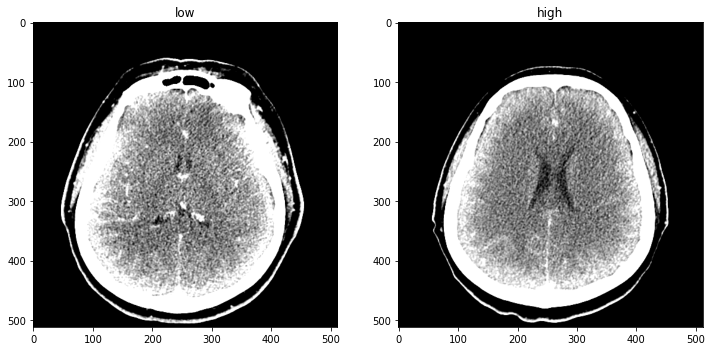

In [16]:
check_ds = Dataset(data=test_files, transform=test_transforms)
# check_loader = DataLoader(check_ds, batch_size=1, shuffle=False)
# check_data = next(iter(check_loader))

check_data = check_ds[4]

print(check_data['low_meta_dict']['filename_or_obj'])
print(check_data['high_meta_dict']['filename_or_obj'])

low = (check_data["low"][0])
high = (check_data["high"][0])
print(f"image shape: {low.shape}")
print(low.max(), low.min(), low.dtype, low.shape)

plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("low")
plt.imshow(visual_windowing(low), cmap="gray")

plt.subplot(1, 2, 2)
plt.title("high")
plt.imshow(visual_windowing(high), cmap="gray")

plt.show()

In [17]:
import multiprocessing
print("CPU 갯수 = ", multiprocessing.cpu_count())

# Cachedataset 이거 뭔가 문제가 있음...
test_ds = Dataset(data=test_files, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=16, drop_last=False)

CPU 갯수 =  32


## TEST

In [18]:
## 그밖에 부수적인 functions 설정하기
fn_tonumpy = lambda x: x.cpu().detach().numpy().transpose(0, 2, 3, 1)
fn_denorm  = lambda x: (x * 0.5) + 0.5
fn_denorm_window  = visual_windowing

In [19]:
def return_preprocessing(x):
    x = (4095.0)*x - 1024.0
    return x

def return_preprocessing_for_dcm(x):
    x = (4095.0)*x
    return x

In [20]:
import numpy as np
from pydicom import dcmread

def save_dicom(original_dcm_path, np_img, save_path):
    dcm = dcmread(original_dcm_path)
    
    print(np_img.max(), np_img.min(), np_img.dtype)
    
    dcm.PixelData = np_img.astype('uint16').squeeze().tobytes()
    
    dcm.save_as(save_path)
    print(save_path)

In [23]:
test_low2high_save_folder = '/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_'+str(epoch) + '/low2high/'
test_low2high_png_folder  = '/workspace/sunggu/4.Dose_img2img/Predictions/Test/png/Follow_test_OT_cyclegan_2d_epoch_'+str(epoch) + '/low2high/'

with torch.no_grad():
    # Model 선언
    netG_low_2_high.eval()

    test_iterator = tqdm(test_loader, desc='Test', file=sys.stdout)    
    for batch_data in test_iterator:

        os.makedirs(test_low2high_save_folder+batch_data['dcm_low'][0].split('/')[8], mode=0o777, exist_ok=True)
        os.makedirs(test_low2high_png_folder+batch_data['dcm_low'][0].split('/')[8], mode=0o777, exist_ok=True)
        
        # forward pass
        input_low  = batch_data['low'].to(device)
        input_high = batch_data['high'].to(device)
        
        # Forward Generator
        output_high = netG_low_2_high(input_low)

        # 저장하기
        input_low_dcm   = fn_tonumpy(return_preprocessing_for_dcm(fn_denorm(input_low)))
        output_high_dcm = fn_tonumpy(return_preprocessing_for_dcm(fn_denorm(output_high)))

        save_dicom(batch_data['dcm_low'][0],  input_low_dcm,   test_low2high_save_folder+batch_data['dcm_low'][0].split('/')[8]+'/gt_low_' +batch_data['dcm_low'][0].split('/')[-1])        
        save_dicom(batch_data['dcm_low'][0],  output_high_dcm, test_low2high_save_folder+batch_data['dcm_low'][0].split('/')[8]+'/pred_high_' +batch_data['dcm_low'][0].split('/')[-1])        

        
        # png Save
        input_low   = fn_denorm_window(fn_tonumpy((input_low)))
        output_high = fn_denorm_window(fn_tonumpy((output_high)))

        input_low   = np.clip(input_low, a_min=0, a_max=1)
        output_high = np.clip(output_high, a_min=0, a_max=1)
        
        plt.imsave(test_low2high_png_folder+batch_data['dcm_low'][0].split('/')[8]+'/gt_low_' +batch_data['dcm_low'][0].split('/')[-1].replace('.dcm', '.png'),
                   input_low[0].squeeze(),   cmap="gray")
        plt.imsave(test_low2high_png_folder+batch_data['dcm_low'][0].split('/')[8]+'/pred_high_' +batch_data['dcm_low'][0].split('/')[-1].replace('.dcm', '.png'),
                   output_high[0].squeeze(),   cmap="gray")        
                
#         plt.figure(figsize=(12,12))
#         plt.subplot(131)
#         plt.imshow(input_low.squeeze(), 'gray')
#         plt.subplot(132)
#         plt.imshow(input_high.squeeze(), 'gray')
#         plt.subplot(133)
#         plt.imshow(output_high.squeeze(), 'gray')
#         plt.show()
                                     
          

Test:   0%|          | 0/1020 [00:00<?, ?it/s]2744.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/51545804/gt_low_000000000.dcm
2732.4473 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/51545804/pred_high_000000000.dcm
Test:   0%|          | 1/1020 [00:01<23:52,  1.41s/it]2728.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/51545804/gt_low_000000001.dcm
2716.11 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/51545804/pred_high_000000001.dcm
Test:   0%|          | 2/1020 [00:01<12:32,  1.35it/s]2720.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/51545804/gt_low_000000002.dcm
2707.6846 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_

Test:   2%|▏         | 23/1020 [00:06<03:54,  4.26it/s]2726.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/51545804/gt_low_000000023.dcm
2712.6768 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/51545804/pred_high_000000023.dcm
Test:   2%|▏         | 24/1020 [00:07<03:58,  4.17it/s]2707.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/51545804/gt_low_000000024.dcm
2701.8052 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/51545804/pred_high_000000024.dcm
Test:   2%|▏         | 25/1020 [00:07<03:49,  4.33it/s]2740.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/51545804/gt_low_000000025.dcm
2738.181 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Fol

Test:   5%|▍         | 46/1020 [00:11<03:06,  5.22it/s]2776.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/51545804/gt_low_000000046.dcm
2767.3757 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/51545804/pred_high_000000046.dcm
Test:   5%|▍         | 47/1020 [00:12<03:08,  5.16it/s]2763.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/51545804/gt_low_000000047.dcm
2743.4448 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/51545804/pred_high_000000047.dcm
Test:   5%|▍         | 48/1020 [00:12<03:01,  5.36it/s]2568.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/51545804/gt_low_000000048.dcm
2551.4248 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Fo

Test:   7%|▋         | 69/1020 [00:15<02:38,  5.99it/s]2167.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/51545804/gt_low_000000069.dcm
2239.807 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/51545804/pred_high_000000069.dcm
Test:   7%|▋         | 70/1020 [00:15<02:53,  5.47it/s]2420.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/51545804/gt_low_000000070.dcm
2562.2256 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/51545804/pred_high_000000070.dcm
Test:   7%|▋         | 71/1020 [00:16<02:52,  5.51it/s]2424.0 0.99999994 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/51545804/gt_low_000000071.dcm
2559.3687 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/

Test:   9%|▉         | 92/1020 [00:20<03:01,  5.10it/s]2168.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/51545804/gt_low_000000092.dcm
2609.8247 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/51545804/pred_high_000000092.dcm
Test:   9%|▉         | 93/1020 [00:20<02:57,  5.22it/s]2561.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52079564/gt_low_000000000.dcm
2553.6042 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52079564/pred_high_000000000.dcm
Test:   9%|▉         | 94/1020 [00:20<03:09,  4.88it/s]2552.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52079564/gt_low_000000001.dcm
2542.8757 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Fo

Test:  11%|█▏        | 115/1020 [00:25<03:05,  4.87it/s]2647.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52079564/gt_low_000000022.dcm
2645.0994 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52079564/pred_high_000000022.dcm
Test:  11%|█▏        | 116/1020 [00:25<02:57,  5.08it/s]2687.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52079564/gt_low_000000023.dcm
2681.6035 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52079564/pred_high_000000023.dcm
Test:  11%|█▏        | 117/1020 [00:25<02:51,  5.28it/s]2636.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52079564/gt_low_000000024.dcm
2638.4424 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm

Test:  14%|█▎        | 138/1020 [00:29<02:40,  5.51it/s]2470.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52079564/gt_low_000000045.dcm
2547.8987 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52079564/pred_high_000000045.dcm
Test:  14%|█▎        | 139/1020 [00:29<02:39,  5.53it/s]2236.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52079564/gt_low_000000046.dcm
2310.807 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52079564/pred_high_000000046.dcm
Test:  14%|█▎        | 140/1020 [00:29<03:40,  3.99it/s]2226.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52079564/gt_low_000000047.dcm
2341.439 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/F

Test:  16%|█▌        | 161/1020 [00:34<03:21,  4.25it/s]2165.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52079564/gt_low_000000068.dcm
2297.9543 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52079564/pred_high_000000068.dcm
Test:  16%|█▌        | 162/1020 [00:34<03:11,  4.47it/s]2241.0 0.99999994 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52079564/gt_low_000000069.dcm
2459.3928 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52079564/pred_high_000000069.dcm
Test:  16%|█▌        | 163/1020 [00:34<02:59,  4.78it/s]2258.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52079564/gt_low_000000070.dcm
2454.8674 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/T

Test:  18%|█▊        | 184/1020 [00:39<03:18,  4.21it/s]2697.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52100901/gt_low_000000014.dcm
2682.1667 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52100901/pred_high_000000014.dcm
Test:  18%|█▊        | 185/1020 [00:39<03:15,  4.27it/s]2691.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52100901/gt_low_000000015.dcm
2677.877 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52100901/pred_high_000000015.dcm
Test:  18%|█▊        | 186/1020 [00:39<03:12,  4.33it/s]2712.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52100901/gt_low_000000016.dcm
2700.3926 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/

Test:  20%|██        | 207/1020 [00:43<02:04,  6.51it/s]4095.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52100901/gt_low_000000037.dcm
4066.936 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52100901/pred_high_000000037.dcm
Test:  20%|██        | 208/1020 [00:43<02:02,  6.63it/s]4095.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52100901/gt_low_000000038.dcm
4054.5742 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52100901/pred_high_000000038.dcm
Test:  20%|██        | 209/1020 [00:43<01:58,  6.83it/s]4095.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52100901/gt_low_000000039.dcm
4062.6094 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/

Test:  23%|██▎       | 230/1020 [00:47<02:09,  6.09it/s]2280.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52100901/gt_low_000000060.dcm
2355.021 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52100901/pred_high_000000060.dcm
Test:  23%|██▎       | 231/1020 [00:47<02:12,  5.95it/s]2521.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52100901/gt_low_000000061.dcm
2590.6523 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52100901/pred_high_000000061.dcm
Test:  23%|██▎       | 232/1020 [00:47<02:08,  6.12it/s]2604.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52100901/gt_low_000000062.dcm
2600.9463 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/

Test:  25%|██▍       | 253/1020 [00:50<02:10,  5.89it/s]2499.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52100901/gt_low_000000083.dcm
2605.1753 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52100901/pred_high_000000083.dcm
Test:  25%|██▍       | 254/1020 [00:51<02:17,  5.58it/s]2482.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52100901/gt_low_000000084.dcm
2511.3428 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52100901/pred_high_000000084.dcm
Test:  25%|██▌       | 255/1020 [00:51<03:21,  3.79it/s]2480.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52100901/gt_low_000000085.dcm
2504.1528 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm

Test:  27%|██▋       | 276/1020 [00:55<02:13,  5.56it/s]2164.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52100901/gt_low_000000106.dcm
2181.9783 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52100901/pred_high_000000106.dcm
Test:  27%|██▋       | 277/1020 [00:55<02:07,  5.84it/s]2095.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52100901/gt_low_000000107.dcm
2120.8318 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52100901/pred_high_000000107.dcm
Test:  27%|██▋       | 278/1020 [00:55<02:02,  6.07it/s]2109.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52100901/gt_low_000000108.dcm
2138.4463 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm

Test:  29%|██▉       | 299/1020 [01:01<03:24,  3.53it/s]2724.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52347894/gt_low_000000013.dcm
2674.1213 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52347894/pred_high_000000013.dcm
Test:  29%|██▉       | 300/1020 [01:02<03:13,  3.73it/s]2698.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52347894/gt_low_000000014.dcm
2653.6138 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52347894/pred_high_000000014.dcm
Test:  30%|██▉       | 301/1020 [01:02<03:12,  3.73it/s]2696.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52347894/gt_low_000000015.dcm
2650.7769 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm

Test:  32%|███▏      | 322/1020 [01:06<01:42,  6.83it/s]2731.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52347894/gt_low_000000036.dcm
2669.5344 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52347894/pred_high_000000036.dcm
Test:  32%|███▏      | 323/1020 [01:06<01:41,  6.88it/s]2747.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52347894/gt_low_000000037.dcm
2685.7927 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52347894/pred_high_000000037.dcm
Test:  32%|███▏      | 324/1020 [01:06<01:41,  6.85it/s]2757.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52347894/gt_low_000000038.dcm
2696.6548 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm

Test:  34%|███▍      | 345/1020 [01:10<01:59,  5.63it/s]2827.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52347894/gt_low_000000059.dcm
2765.4556 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52347894/pred_high_000000059.dcm
Test:  34%|███▍      | 346/1020 [01:10<01:57,  5.73it/s]2829.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52347894/gt_low_000000060.dcm
2762.256 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52347894/pred_high_000000060.dcm
Test:  34%|███▍      | 347/1020 [01:11<01:54,  5.86it/s]2821.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52347894/gt_low_000000061.dcm
2754.405 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/F

Test:  36%|███▌      | 368/1020 [01:15<02:21,  4.61it/s]2498.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52347894/gt_low_000000082.dcm
2610.3552 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52347894/pred_high_000000082.dcm
Test:  36%|███▌      | 369/1020 [01:15<02:17,  4.74it/s]2494.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52347894/gt_low_000000083.dcm
2634.7817 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52347894/pred_high_000000083.dcm
Test:  36%|███▋      | 370/1020 [01:15<02:16,  4.76it/s]2529.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52347894/gt_low_000000084.dcm
2412.4575 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm

Test:  38%|███▊      | 391/1020 [01:20<01:28,  7.12it/s]2305.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52347894/gt_low_000000105.dcm
2465.891 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52347894/pred_high_000000105.dcm
Test:  38%|███▊      | 392/1020 [01:20<01:27,  7.20it/s]2220.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52347894/gt_low_000000106.dcm
2375.686 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52347894/pred_high_000000106.dcm
Test:  39%|███▊      | 393/1020 [01:20<01:28,  7.09it/s]2196.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52347894/gt_low_000000107.dcm
2350.4915 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/F

Test:  41%|████      | 414/1020 [01:24<02:02,  4.93it/s]2598.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52351259/gt_low_000000017.dcm
2582.0986 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52351259/pred_high_000000017.dcm
Test:  41%|████      | 415/1020 [01:24<01:54,  5.29it/s]2622.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52351259/gt_low_000000018.dcm
2611.6946 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52351259/pred_high_000000018.dcm
Test:  41%|████      | 416/1020 [01:24<01:47,  5.63it/s]2659.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52351259/gt_low_000000019.dcm
2671.0996 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm

Test:  43%|████▎     | 437/1020 [01:28<01:27,  6.69it/s]3832.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52351259/gt_low_000000040.dcm
3907.8376 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52351259/pred_high_000000040.dcm
Test:  43%|████▎     | 438/1020 [01:28<01:22,  7.02it/s]3364.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52351259/gt_low_000000041.dcm
3434.012 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52351259/pred_high_000000041.dcm
Test:  43%|████▎     | 439/1020 [01:28<01:20,  7.25it/s]2742.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52351259/gt_low_000000042.dcm
2716.2126 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/

Test:  45%|████▌     | 460/1020 [01:31<01:29,  6.25it/s]2394.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52351259/gt_low_000000063.dcm
2307.3794 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52351259/pred_high_000000063.dcm
Test:  45%|████▌     | 461/1020 [01:31<01:27,  6.37it/s]2448.0 1.9999999 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52351259/gt_low_000000064.dcm
2395.245 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52351259/pred_high_000000064.dcm
Test:  45%|████▌     | 462/1020 [01:31<01:24,  6.62it/s]2500.0 0.99999994 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52351259/gt_low_000000065.dcm
2473.862 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictio

Test:  47%|████▋     | 483/1020 [01:35<01:20,  6.68it/s]2243.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52351259/gt_low_000000086.dcm
2383.9324 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52351259/pred_high_000000086.dcm
Test:  47%|████▋     | 484/1020 [01:35<01:28,  6.09it/s]2260.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52351259/gt_low_000000087.dcm
2399.4062 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52351259/pred_high_000000087.dcm
Test:  48%|████▊     | 485/1020 [01:35<01:32,  5.76it/s]2291.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52351259/gt_low_000000088.dcm
2442.3943 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm

Test:  50%|████▉     | 506/1020 [01:40<01:49,  4.70it/s]2721.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52465336/gt_low_000000018.dcm
2666.3376 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52465336/pred_high_000000018.dcm
Test:  50%|████▉     | 507/1020 [01:40<01:47,  4.78it/s]2730.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52465336/gt_low_000000019.dcm
2675.31 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52465336/pred_high_000000019.dcm
Test:  50%|████▉     | 508/1020 [01:40<01:47,  4.76it/s]2705.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52465336/gt_low_000000020.dcm
2652.795 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Fo

Test:  52%|█████▏    | 529/1020 [01:44<01:14,  6.60it/s]3693.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52465336/gt_low_000000041.dcm
3693.3188 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52465336/pred_high_000000041.dcm
Test:  52%|█████▏    | 530/1020 [01:44<01:17,  6.35it/s]3998.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52465336/gt_low_000000042.dcm
3909.886 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52465336/pred_high_000000042.dcm
Test:  52%|█████▏    | 531/1020 [01:44<01:15,  6.45it/s]4095.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52465336/gt_low_000000043.dcm
3964.98 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Fo

Test:  54%|█████▍    | 552/1020 [01:47<01:15,  6.18it/s]2838.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52465336/gt_low_000000064.dcm
2777.559 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52465336/pred_high_000000064.dcm
Test:  54%|█████▍    | 553/1020 [01:48<01:20,  5.82it/s]2650.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52465336/gt_low_000000065.dcm
2593.06 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52465336/pred_high_000000065.dcm
Test:  54%|█████▍    | 554/1020 [01:48<01:23,  5.61it/s]2425.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52465336/gt_low_000000066.dcm
2404.6528 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Fo

Test:  56%|█████▋    | 575/1020 [01:51<01:27,  5.10it/s]2244.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52465336/gt_low_000000087.dcm
2138.9587 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52465336/pred_high_000000087.dcm
Test:  56%|█████▋    | 576/1020 [01:52<01:31,  4.86it/s]2133.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52465336/gt_low_000000088.dcm
2039.5442 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52465336/pred_high_000000088.dcm
Test:  57%|█████▋    | 577/1020 [01:52<01:29,  4.95it/s]2387.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52465336/gt_low_000000089.dcm
2284.528 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/

Test:  59%|█████▊    | 598/1020 [01:56<02:00,  3.50it/s]2334.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52465336/gt_low_000000110.dcm
2349.174 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52465336/pred_high_000000110.dcm
Test:  59%|█████▊    | 599/1020 [01:56<01:52,  3.73it/s]2330.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52465336/gt_low_000000111.dcm
2352.6177 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52465336/pred_high_000000111.dcm
Test:  59%|█████▉    | 600/1020 [01:57<01:45,  3.96it/s]2364.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52465336/gt_low_000000112.dcm
2385.6729 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/

Test:  61%|██████    | 621/1020 [02:02<01:55,  3.45it/s]2627.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52561195/gt_low_000000003.dcm
2592.1655 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52561195/pred_high_000000003.dcm
Test:  61%|██████    | 622/1020 [02:02<01:56,  3.42it/s]2628.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52561195/gt_low_000000004.dcm
2586.0046 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52561195/pred_high_000000004.dcm
Test:  61%|██████    | 623/1020 [02:02<01:52,  3.54it/s]2655.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52561195/gt_low_000000005.dcm
2612.8682 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm

Test:  63%|██████▎   | 644/1020 [02:07<01:28,  4.27it/s]2765.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52561195/gt_low_000000026.dcm
2715.8286 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52561195/pred_high_000000026.dcm
Test:  63%|██████▎   | 645/1020 [02:07<01:26,  4.36it/s]2730.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52561195/gt_low_000000027.dcm
2684.1294 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52561195/pred_high_000000027.dcm
Test:  63%|██████▎   | 646/1020 [02:08<01:23,  4.45it/s]2694.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52561195/gt_low_000000028.dcm
2648.5447 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm

Test:  65%|██████▌   | 667/1020 [02:12<01:10,  5.02it/s]4095.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52561195/gt_low_000000049.dcm
4080.2341 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52561195/pred_high_000000049.dcm
Test:  65%|██████▌   | 668/1020 [02:12<01:09,  5.10it/s]4095.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52561195/gt_low_000000050.dcm
4067.5447 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52561195/pred_high_000000050.dcm
Test:  66%|██████▌   | 669/1020 [02:12<01:07,  5.22it/s]4095.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52561195/gt_low_000000051.dcm
4036.3118 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm

Test:  68%|██████▊   | 690/1020 [02:17<01:35,  3.47it/s]2357.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52561195/gt_low_000000072.dcm
2313.1655 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52561195/pred_high_000000072.dcm
Test:  68%|██████▊   | 691/1020 [02:17<01:23,  3.92it/s]2314.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52561195/gt_low_000000073.dcm
2285.6938 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52561195/pred_high_000000073.dcm
Test:  68%|██████▊   | 692/1020 [02:17<01:15,  4.35it/s]2340.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52561195/gt_low_000000074.dcm
2330.326 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/

Test:  70%|██████▉   | 713/1020 [02:21<01:10,  4.36it/s]2432.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52561195/gt_low_000000095.dcm
2336.121 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52561195/pred_high_000000095.dcm
Test:  70%|███████   | 714/1020 [02:22<01:08,  4.45it/s]2460.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52561195/gt_low_000000096.dcm
2358.12 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52561195/pred_high_000000096.dcm
Test:  70%|███████   | 715/1020 [02:22<01:10,  4.36it/s]2480.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52561195/gt_low_000000097.dcm
2390.061 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Fol

Test:  72%|███████▏  | 736/1020 [02:26<00:40,  7.02it/s]2290.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52561195/gt_low_000000118.dcm
2393.4414 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52561195/pred_high_000000118.dcm
Test:  72%|███████▏  | 737/1020 [02:26<00:38,  7.28it/s]2170.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52561195/gt_low_000000119.dcm
2285.054 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52561195/pred_high_000000119.dcm
Test:  72%|███████▏  | 738/1020 [02:26<00:37,  7.42it/s]2378.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52561195/gt_low_000000120.dcm
2474.0417 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/

Test:  74%|███████▍  | 759/1020 [02:30<00:50,  5.18it/s]2624.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52584996/gt_low_000000013.dcm
2631.0684 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52584996/pred_high_000000013.dcm
Test:  75%|███████▍  | 760/1020 [02:30<00:51,  5.09it/s]2774.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52584996/gt_low_000000014.dcm
2772.236 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52584996/pred_high_000000014.dcm
Test:  75%|███████▍  | 761/1020 [02:30<00:50,  5.09it/s]2816.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52584996/gt_low_000000015.dcm
2814.0781 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/

Test:  77%|███████▋  | 782/1020 [02:34<00:43,  5.52it/s]4095.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52584996/gt_low_000000036.dcm
4071.0254 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52584996/pred_high_000000036.dcm
Test:  77%|███████▋  | 783/1020 [02:34<00:39,  5.95it/s]4095.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52584996/gt_low_000000037.dcm
4080.5396 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52584996/pred_high_000000037.dcm
Test:  77%|███████▋  | 784/1020 [02:34<00:36,  6.41it/s]4095.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52584996/gt_low_000000038.dcm
4083.5132 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm

Test:  79%|███████▉  | 805/1020 [02:38<00:43,  4.98it/s]2403.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52584996/gt_low_000000059.dcm
2413.1414 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52584996/pred_high_000000059.dcm
Test:  79%|███████▉  | 806/1020 [02:38<00:40,  5.23it/s]2421.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52584996/gt_low_000000060.dcm
2437.8428 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52584996/pred_high_000000060.dcm
Test:  79%|███████▉  | 807/1020 [02:38<00:39,  5.42it/s]2457.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52584996/gt_low_000000061.dcm
2460.614 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/

Test:  81%|████████  | 828/1020 [02:42<00:29,  6.60it/s]2092.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52584996/gt_low_000000082.dcm
2225.0798 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52584996/pred_high_000000082.dcm
Test:  81%|████████▏ | 829/1020 [02:42<00:29,  6.39it/s]2715.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52957121/gt_low_000000000.dcm
2702.4448 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52957121/pred_high_000000000.dcm
Test:  81%|████████▏ | 830/1020 [02:42<00:30,  6.31it/s]2686.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52957121/gt_low_000000001.dcm
2679.2732 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm

Test:  83%|████████▎ | 851/1020 [02:47<00:36,  4.61it/s]2893.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52957121/gt_low_000000022.dcm
2883.657 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52957121/pred_high_000000022.dcm
Test:  84%|████████▎ | 852/1020 [02:47<00:34,  4.84it/s]2817.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52957121/gt_low_000000023.dcm
2812.7007 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52957121/pred_high_000000023.dcm
Test:  84%|████████▎ | 853/1020 [02:47<00:33,  5.06it/s]2733.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52957121/gt_low_000000024.dcm
2730.7512 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/

Test:  86%|████████▌ | 874/1020 [02:50<00:21,  6.64it/s]2961.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52957121/gt_low_000000045.dcm
2909.7883 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52957121/pred_high_000000045.dcm
Test:  86%|████████▌ | 875/1020 [02:50<00:23,  6.15it/s]2850.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52957121/gt_low_000000046.dcm
2827.6575 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52957121/pred_high_000000046.dcm
Test:  86%|████████▌ | 876/1020 [02:50<00:23,  6.06it/s]2856.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52957121/gt_low_000000047.dcm
2825.6318 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm

Test:  88%|████████▊ | 897/1020 [02:54<00:19,  6.39it/s]2093.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52957121/gt_low_000000068.dcm
2027.0724 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52957121/pred_high_000000068.dcm
Test:  88%|████████▊ | 898/1020 [02:54<00:18,  6.64it/s]2149.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52957121/gt_low_000000069.dcm
2073.1372 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52957121/pred_high_000000069.dcm
Test:  88%|████████▊ | 899/1020 [02:54<00:17,  6.79it/s]2472.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52957121/gt_low_000000070.dcm
2445.6936 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm

Test:  90%|█████████ | 920/1020 [02:58<00:22,  4.37it/s]2223.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52957121/gt_low_000000091.dcm
2269.5898 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52957121/pred_high_000000091.dcm
Test:  90%|█████████ | 921/1020 [02:59<00:23,  4.23it/s]2271.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52957121/gt_low_000000092.dcm
2319.8147 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52957121/pred_high_000000092.dcm
Test:  90%|█████████ | 922/1020 [02:59<00:21,  4.57it/s]2395.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/52957121/gt_low_000000093.dcm
2449.5051 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm

Test:  92%|█████████▏| 943/1020 [03:03<00:13,  5.83it/s]2680.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/53782539/gt_low_000000018.dcm
2680.0598 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/53782539/pred_high_000000018.dcm
Test:  93%|█████████▎| 944/1020 [03:03<00:13,  5.80it/s]2695.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/53782539/gt_low_000000019.dcm
2695.77 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/53782539/pred_high_000000019.dcm
Test:  93%|█████████▎| 945/1020 [03:03<00:12,  5.86it/s]2758.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/53782539/gt_low_000000020.dcm
2753.8657 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/F

Test:  95%|█████████▍| 966/1020 [03:08<00:10,  4.91it/s]3896.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/53782539/gt_low_000000041.dcm
3784.62 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/53782539/pred_high_000000041.dcm
Test:  95%|█████████▍| 967/1020 [03:08<00:10,  5.04it/s]3830.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/53782539/gt_low_000000042.dcm
3822.2964 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/53782539/pred_high_000000042.dcm
Test:  95%|█████████▍| 968/1020 [03:08<00:10,  4.92it/s]3640.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/53782539/gt_low_000000043.dcm
3688.1816 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/F

Test:  97%|█████████▋| 989/1020 [03:11<00:04,  7.39it/s]2247.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/53782539/gt_low_000000064.dcm
2127.0242 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/53782539/pred_high_000000064.dcm
Test:  97%|█████████▋| 990/1020 [03:12<00:04,  7.50it/s]2218.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/53782539/gt_low_000000065.dcm
2106.4902 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/53782539/pred_high_000000065.dcm
Test:  97%|█████████▋| 991/1020 [03:12<00:03,  7.30it/s]2241.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/53782539/gt_low_000000066.dcm
2149.6619 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm

Test:  99%|█████████▉| 1012/1020 [03:15<00:01,  4.86it/s]2045.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/53782539/gt_low_000000087.dcm
2110.5476 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/53782539/pred_high_000000087.dcm
Test:  99%|█████████▉| 1013/1020 [03:15<00:01,  4.73it/s]2097.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/53782539/gt_low_000000088.dcm
2174.0833 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/53782539/pred_high_000000088.dcm
Test:  99%|█████████▉| 1014/1020 [03:16<00:01,  4.37it/s]2310.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_OT_cyclegan_2d_epoch_340/low2high/53782539/gt_low_000000089.dcm
2409.972 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/d